In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import time
import json

from IPython import display

In [2]:
BATCH_SIZE = 32
MAP_SIZE = 32
LR_D = LR_G = 0.00005

In [3]:
rm -rf sample_data/

In [4]:
# TODO: Change path here if different
train_images_path = 'example_super_mario_bros_1.json'
train_images_gt_path = 'example_super_mario_bros_2.json'
train_images = np.array(json.load(open(train_images_path)))
train_images_gt = np.array(json.load(open(train_images_gt_path)))
print(train_images.shape)
print(train_images_gt.shape)

(2518, 14, 28)
(2518, 14, 28)


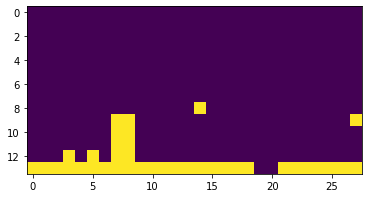

In [5]:
plt.imshow(train_images[50])

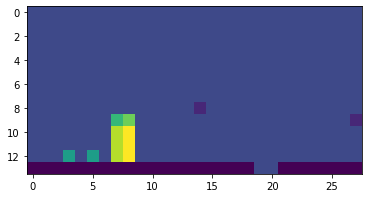

In [6]:
plt.imshow(train_images_gt[50])

In [7]:
train_size, x_dims, y_dims = train_images.shape
z_dims = np.amax(train_images) + np.amax(train_images_gt) + 2
gt_dims = np.amax(train_images_gt) + 1

print(train_size, x_dims, y_dims, z_dims)

def get_processed_images(images, encoding_index=2):
  train_size, x_dims, y_dims = images.shape
  z_dims = np.amax(images) + 1 # Number of different title types

  images_onehot = np.eye(z_dims, dtype='uint8')[images]
  print(images_onehot.shape) # (train_size, x_dims, y_dims, z_dims)

  images = np.zeros((train_size, MAP_SIZE, MAP_SIZE, z_dims))
  print(images.shape)

  images[:, :, :, encoding_index] = 1.0  # Fill with empty space 

  images[:train_size, :x_dims, :y_dims, :] = images_onehot
  print(images.shape)

  return images

# TODO: Change empty space encoding here if different
train_images = get_processed_images(train_images, 0)
train_images_gt = get_processed_images(train_images_gt)

2518 14 28 15
(2518, 14, 28, 2)
(2518, 32, 32, 2)
(2518, 32, 32, 2)
(2518, 14, 28, 13)
(2518, 32, 32, 13)
(2518, 32, 32, 13)


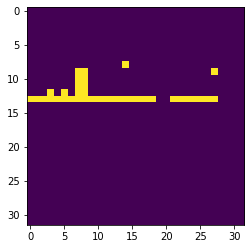

In [8]:
plt.imshow(np.argmax(train_images[50], axis=2))

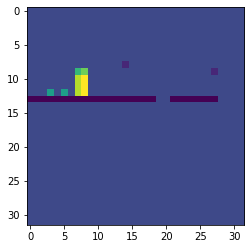

In [9]:
plt.imshow(np.argmax(train_images_gt[50], axis=2))

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_images_gt)).shuffle(train_size).batch(BATCH_SIZE)

In [11]:
train_dataset

<BatchDataset shapes: ((None, 32, 32, 2), (None, 32, 32, 13)), types: (tf.float64, tf.float64)>

In [12]:
def make_discriminator_model(n_extra_layers=0):
  assert MAP_SIZE % 16 == 0

  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', use_bias=False, input_shape=(MAP_SIZE, MAP_SIZE, z_dims)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU(alpha=0.2))

  image_size, n_filters = MAP_SIZE / 2, 64

  # Extra layers
  for i in range(n_extra_layers):
    model.add(layers.Conv2D(n_filters, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

  while image_size > 4:
    n_filters *= 2
    model.add(layers.Conv2D(n_filters, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    image_size /= 2

  # Input here is (BATCH_SIZE x 4 x 4 x n_filters)
  model.add(layers.Conv2D(1, (4, 4), strides=(1, 1), padding='valid', use_bias=False))
    
  return model

In [13]:
def make_generator_model(n_extra_layers=0):
  assert MAP_SIZE % 16 == 0

  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', use_bias=False, input_shape=(MAP_SIZE, MAP_SIZE, z_dims - gt_dims)))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())

  image_size, n_filters = MAP_SIZE / 2, 64

  # Extra layers
  for i in range(n_extra_layers):
    model.add(layers.Conv2D(n_filters, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

  while image_size > 4:
    n_filters *= 2
    model.add(layers.Conv2D(n_filters, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    image_size /= 2

  # 32 here is the 1/2 * n_channels before last Conv2DTranspose
  image_size, n_filters = 4, 32 * MAP_SIZE / 4

  while image_size < MAP_SIZE / 2:
    n_filters /= 2
    model.add(layers.Conv2DTranspose(n_filters, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    image_size *= 2

  # Extra layers
  for i in range(n_extra_layers):
    model.add(layers.Conv2DTranspose(n_filters, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

  model.add(layers.Conv2DTranspose(gt_dims, (4, 4), strides=(2, 2), padding='same', use_bias=False))
  model.add(layers.ReLU())

  return model

In [14]:
discriminator = make_discriminator_model()
generator = make_generator_model()

In [15]:
print(discriminator.summary())
print(generator.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        15360     
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 64)        256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         131072    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)         5

In [16]:
print(generator(np.random.rand(1, MAP_SIZE, MAP_SIZE, z_dims - gt_dims)).shape)
print(discriminator(np.random.rand(1, MAP_SIZE, MAP_SIZE, z_dims)).shape)

(1, 32, 32, 13)
(1, 1, 1, 1)


In [17]:
def get_discriminator_loss(real_output, generated_output):
  real_loss = tf.reduce_mean(real_output)
  generated_loss = tf.reduce_mean(generated_output)
  total_loss = real_loss - generated_loss

  return total_loss


def get_generator_loss(generated_output, ground_truth):
  return -tf.reduce_mean(generated_output) + tf.reduce_mean(tf.keras.losses.MAE(ground_truth, generated_output), axis=0)
  # return -tf.reduce_mean(generated_output) + 0.01 * tf.reduce_sum(tf.reduce_mean(tf.abs(tf.cast(ground_truth, tf.float32) - generated_output), axis=0))

In [18]:
discriminator_optimizer = tf.optimizers.RMSprop(LR_D)
generator_optimizer = tf.optimizers.RMSprop(LR_G)

In [19]:
def generate_and_save_images(model, epoch, test_input, savefig=False):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(10, 10))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(np.argmax(predictions[i], axis=2))
    plt.axis('off')

  if savefig:
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [20]:
EPOCHS = 5000
num_examples = 16

# Use same test vector to see evolution of generated images over time
test_vector_for_generation = train_images[50:50 + num_examples, :]

In [21]:
def train_step(images, images_gt, update_generator=False):
  # Generating noise from a normal distribution
  discriminator_input = tf.concat([images, images_gt], 3)

  for w in discriminator.trainable_variables:
    w.assign(tf.clip_by_value(w, -0.01, 0.01))
    
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(images, training=True)
    real_output = discriminator(discriminator_input, training=True)
    fake_discriminator_input = tf.concat([tf.cast(images, tf.float32), generated_images], 3)
    generated_output = discriminator(fake_discriminator_input, training=True)

    gen_loss = get_generator_loss(generated_output, images_gt)
    disc_loss = get_discriminator_loss(real_output, generated_output)
        
    gradients_of_discriminator = disc_tape.gradient(-disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    if update_generator:
      gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
      generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

  return gen_loss, disc_loss

In [22]:
def train(dataset, epochs):
  gen_iterations = 0
  for epoch in range(epochs):
    start = time.time()
    disc_iterations = 0
    for i, (images, images_gt) in enumerate(dataset):
      if disc_iterations == 0:
        if gen_iterations < 25 or gen_iterations % 500 == 0:
          disc_iterations = 100
        else:
          disc_iterations = 5
      if disc_iterations == 1 or i == len(dataset) - 1:
        gen_loss, disc_loss = train_step(images, images_gt, True)
        gen_iterations += 1
      else:
        gen_loss, disc_loss = train_step(images, images_gt)
      disc_iterations -= 1

    display.clear_output(wait=True)
    # Save generator every 50 epochs
    if (epoch + 1) % 50 == 0:
      generate_and_save_images(generator, epoch + 1, 
                               test_vector_for_generation, True)
      generator.save('models/generator_color_' + str(epoch + 1))
    else:
      generate_and_save_images(generator, epoch + 1, 
                               test_vector_for_generation)

    print ('Time taken for epoch {} is {} sec'.format(epoch + 1, 
                                                      time.time() - start))
    print("Generator Loss: ", gen_loss)
    print("Discriminator Loss: ", disc_loss)
  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                          epochs,
                          random_vector_for_generation)


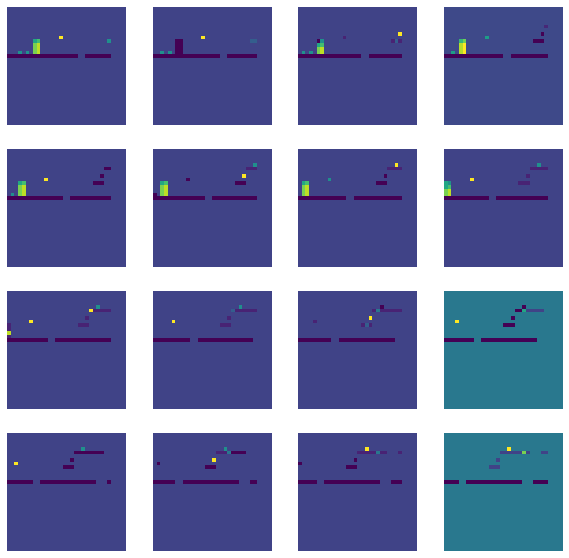

INFO:tensorflow:Assets written to: models/generator_color_2350/assets
Time taken for epoch 2350 is 5.602642774581909 sec
Generator Loss:  tf.Tensor(
[[[0.07878148 0.07878148 0.07878148 ... 0.07878148 0.07878148 0.07878148]
  [0.07878148 0.07878148 0.07878148 ... 0.07878148 0.07878148 0.07878148]
  [0.07878148 0.07878148 0.07878148 ... 0.07878148 0.07878148 0.07878148]
  ...
  [0.07878148 0.07878148 0.07878148 ... 0.07878148 0.07878148 0.07878148]
  [0.07878148 0.07878148 0.07878148 ... 0.07878148 0.07878148 0.07878148]
  [0.07878148 0.07878148 0.07878148 ... 0.07878148 0.07878148 0.07878148]]

 [[0.07884488 0.07884488 0.07884488 ... 0.07884488 0.07884488 0.07884488]
  [0.07884488 0.07884488 0.07884488 ... 0.07884488 0.07884488 0.07884488]
  [0.07884488 0.07884488 0.07884488 ... 0.07884488 0.07884488 0.07884488]
  ...
  [0.07884488 0.07884488 0.07884488 ... 0.07884488 0.07884488 0.07884488]
  [0.07884488 0.07884488 0.07884488 ... 0.07884488 0.07884488 0.07884488]
  [0.07884488 0.0788448

In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
plt.imshow(np.argmax(generator(train_images[50])[0], axis=2))

In [ ]:
generator_saved = tf.keras.models.load_model('models/generator_color_5000')
generator_saved.summary()

In [ ]:
plt.imshow(np.argmax(generator_saved(train_images[50])[0], axis=2))

In [ ]:
!zip -r /content/generator_color_5000.zip /content/models/generator_color_5000